In [82]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')


In [2]:
# read classifier result
key = '1d_precip_location_final1' # not v9 but retrained tuned models 
rname = 'results/classifier_outcomes_%s.csv' % key
outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)

In [3]:
# read benchmark
bm_matrix = pd.read_csv('results/benchmark_matrix_precip_apples.csv', index_col=0, parse_dates=True)
GEFS9_0 = bm_matrix['GEFS_0_0.90']

#### confusion matrix 2*2

In [4]:
# create confusion matrix for outcome matrix at all quantiles
# create ROC matrix for outcome as well - points
binary_outcomes = outcomes.copy() # here outcomes is for test period
for col in binary_outcomes.columns[1:]:
    if binary_outcomes[col].dtypes == 'float64':
        binary_outcomes[col] = (binary_outcomes[col]> 0.5)

leads = [d for d in range(14)]
quantiles = [0.50, 0.75, 0.9, 0.95]
# points = pd.DataFrame(index=leads)
con_matrix = pd.DataFrame(outcomes['ERA5']) #'ERA5'
models=['CNN','MLP']
for m in models:
    for q in quantiles:
#         points['%s_%0.2f_TPR' % (m, q)] = leads
#         points['%s_%0.2f_FPR' % (m, q)] = leads
        for l in leads:
            label = binary_outcomes['ERA5_%0.2f' % q] #'ERA5'
            pred =  binary_outcomes['%s_%d_%0.2f' % (m, l, q)]
            TP = (label&pred)
            con_matrix['%s_%d_%0.2f_TP' % (m, l, q)] = TP
            TN = (~label&~pred)
            con_matrix['%s_%d_%0.2f_TN' % (m, l, q)] = TN
            FP = (~label&pred)
            con_matrix['%s_%d_%0.2f_FP' % (m, l, q)] = FP
            FN = (label&~pred)
            con_matrix['%s_%d_%0.2f_FN' % (m, l, q)] = FN
#             # TP rate = TP/TP+FN
#             TPR = np.sum(TP)/(np.sum(TP)+np.sum(FN))
#             # FP rate = FP/FP+TN
#             FPR = np.sum(FP)/(np.sum(FP)+np.sum(TN))
#             points.loc[l,'%s_%0.2f_TPR' % (m, q)] = TPR
#             points.loc[l,'%s_%0.2f_FPR' % (m, q)] = FPR

#### confusion matrix 2*2*2

In [5]:
leads = [d for d in range(14)]
quantiles = [0.50, 0.75, 0.9, 0.95]

def create_con_matrix_vs_benchmark(key):
    rname = 'results/classifier_outcomes_%s.csv' % key
    outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
    binary_outcomes = outcomes.copy()
    for col in outcomes.columns[1:]:
        if outcomes[col].dtypes == 'float64':
            binary_outcomes[col] = (outcomes[col]> 0.5)


    con_precip_vs = pd.DataFrame(bm_matrix['ERA5']) #'ERA5'

    for q in quantiles:
        for l in leads:
            label = bm_matrix['ERA5_%0.2f' % q] #'ERA5'
            bm_pred =  bm_matrix['GEFS_%d_%0.2f' % (l, q)]
            m_pred = pred =  binary_outcomes['CNN_%d_%0.2f' % (l, q)] # this draws from stored variable - binary_outcomes 
            con_precip_vs['VS_%d_%0.2f_PPN' % (l, q)] = (label&m_pred&~bm_pred) # corrected wrong bm_pred
            con_precip_vs['VS_%d_%0.2f_NNP' % (l, q)] = (~label&~m_pred&bm_pred) # corrected wrong bm_pred
            con_precip_vs['VS_%d_%0.2f_PNP' % (l, q)] = (label&~m_pred&bm_pred ) # changed good bm_pred to incorrect because of FN
            con_precip_vs['VS_%d_%0.2f_NPN' % (l, q)] = (~label&m_pred&~bm_pred) # change good bm_pred to incorrect because of FP
            con_precip_vs['VS_%d_%0.2f_PNN' % (l, q)] = (label&~m_pred&~bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_NPP' % (l, q)] = (~label&m_pred&bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_NNN' % (l, q)] = (~label&~m_pred&~bm_pred) # good as always
            con_precip_vs['VS_%d_%0.2f_PPP' % (l, q)] = (label&m_pred&bm_pred) # good as always
            
    return con_precip_vs

In [7]:
con_cube = create_con_matrix_vs_benchmark('1d_precip_location_final1')

### Generate plots

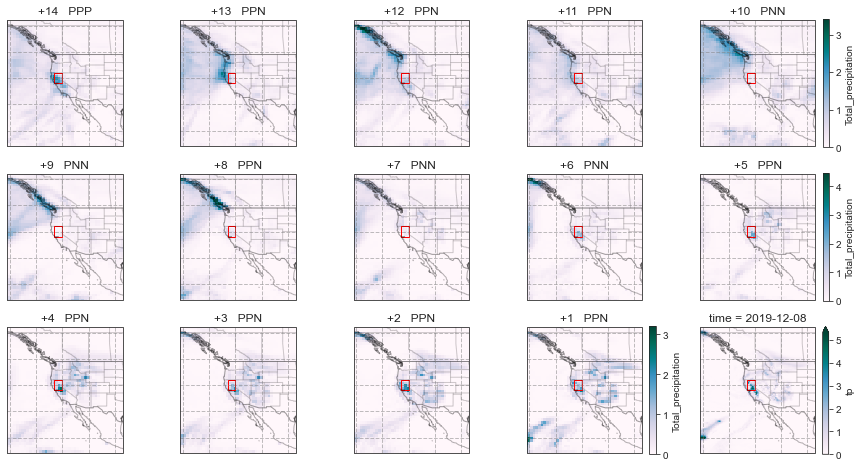

In [25]:
show15days_max('2019-12-08') 

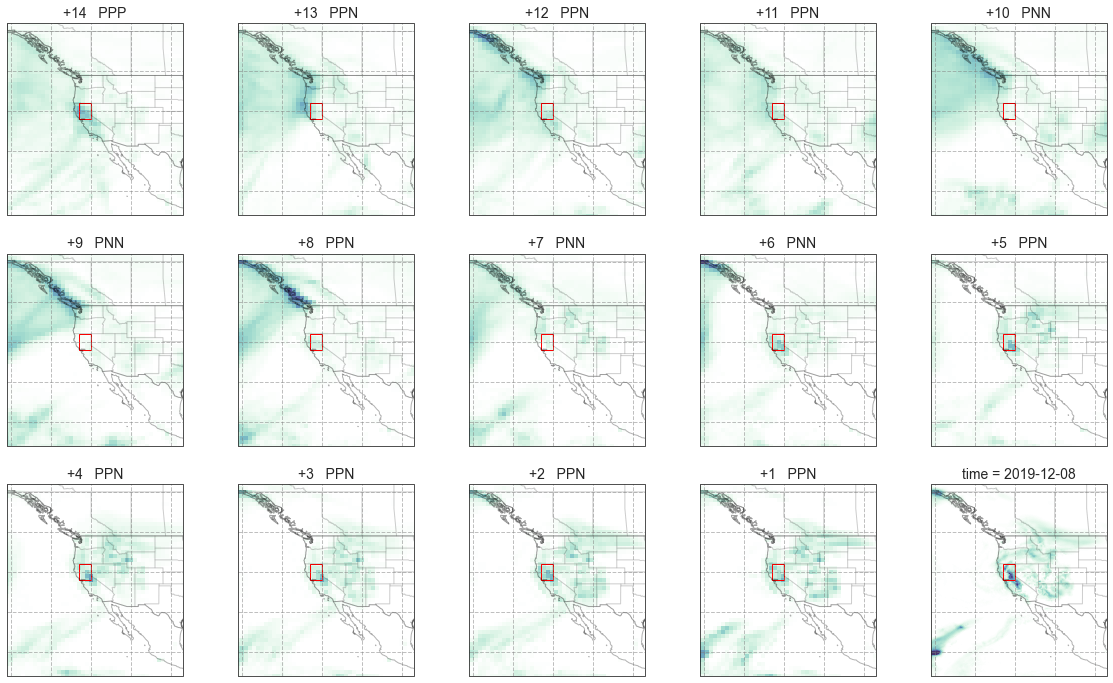

In [114]:
show15days_cut('2019-12-08') 

plt.savefig('/final_figures/8.svg', format='svg', dpi=1200)
plt.savefig('/final_figures/8.png')
plt.show()

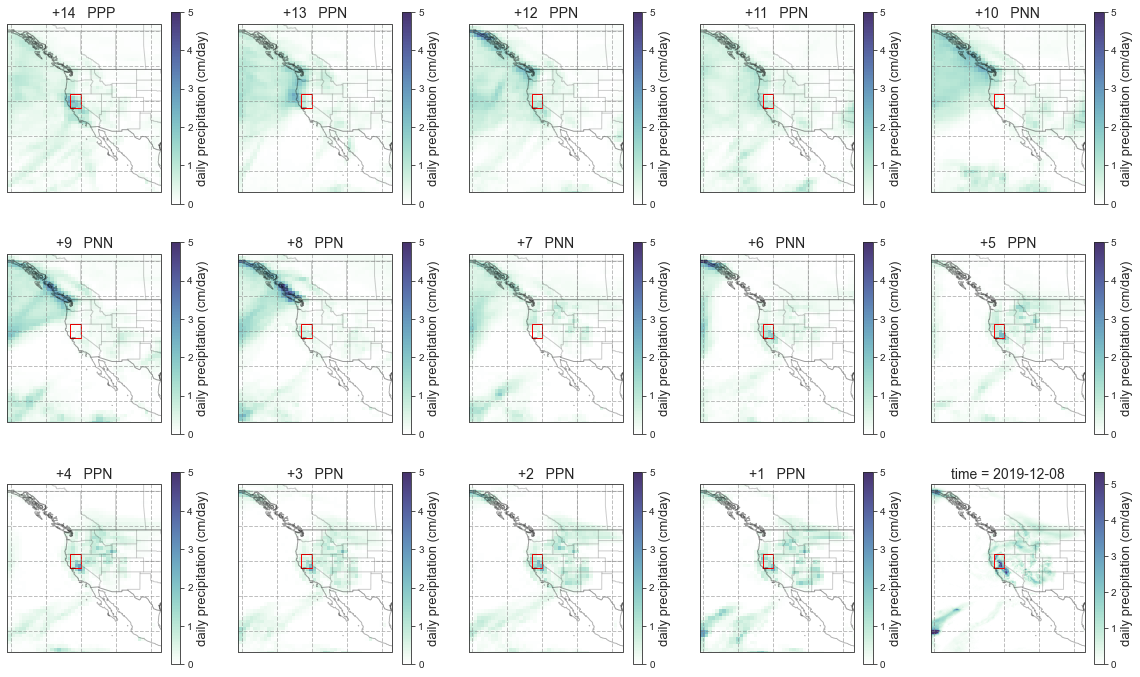

In [118]:
show15days_cut('2019-12-08') 

plt.savefig('/final_figures/8v1.svg', format='svg', dpi=1200)
plt.savefig('/final_figures/8v1.png')
plt.show()

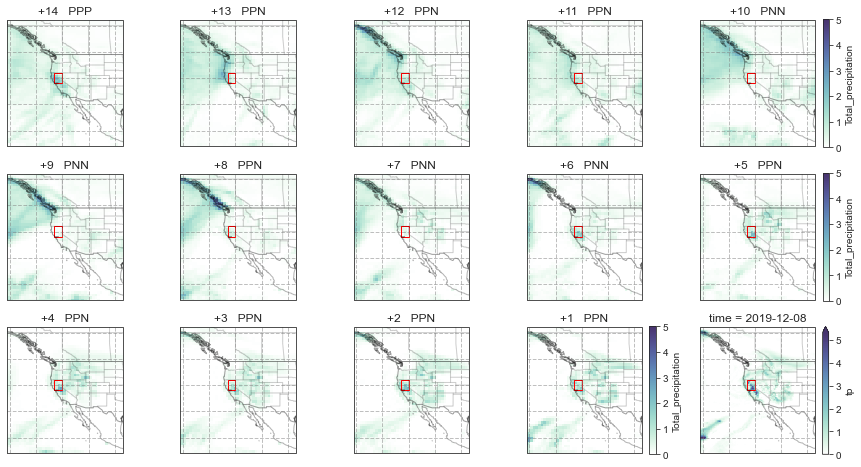

In [52]:
# sns.color_palette("mako_r", as_cmap=True)
cmap = sns.cubehelix_palette(start=.5, rot=-.5, dark=0.25, light=1, gamma=1, hue=1, as_cmap=True)
#sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

show15days_cut('2019-12-08') 

### Functions for plots

In [11]:
import numpy as np 
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import pickle
import datetime as dt

In [12]:

def is_NDJFM(month):
  return (month >= 11) | (month <= 3)

def time_mask(ds):
  return (is_NDJFM(ds['time.month']) & 
         (ds['time.year'] >= 2011) & # test period
         (ds['time.year'] <= 2019)) 

In [13]:

def is_NDJFM_2(month):
  return (month >= 10) | (month <= 3)

def time_mask_2(ds):
  return (is_NDJFM_2(ds['time.month']) & 
         (ds['time.year'] >= 2010) & # test period
         (ds['time.year'] <= 2019)) 

In [14]:
def map_format(ax):
    # ax.add_feature(cartopy.feature.LAND, color='0.2')
    # ax.add_feature(cartopy.feature.OCEAN, color='steelblue')
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.3)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle='-', alpha=0.3)
    ax.add_feature(cartopy.feature.STATES, linestyle='-', alpha=0.1)

    ax.set_extent([-141,-97,14,62], crs=geo)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    ax.add_patch(mpatches.Rectangle(xy=[-123, 38], width=3, height=4,
                                    edgecolor='r',
                                    facecolor='none',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))
    return ax

In [15]:
def map_format_light(ax):
    # ax.add_feature(cartopy.feature.LAND, color='0.2')
    # ax.add_feature(cartopy.feature.OCEAN, color='steelblue')
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', color='lightgray', alpha=0.3)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle='-', color='lightgray', alpha=0.3)
    ax.add_feature(cartopy.feature.STATES, linestyle='-', edgecolor='lightgray', alpha=0.3)

    ax.set_extent([-141,-97,14,62], crs=geo)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    ax.add_patch(mpatches.Rectangle(xy=[-123, 38], width=3, height=4,
                                    edgecolor='r',
                                    facecolor='none',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))
    return ax

In [16]:
geo = ccrs.PlateCarree()

#### plot 14 days

In [10]:
# the axis scale will be self adjusting based on the maximum precipation
def show15days_max(day):
    
    # find out categories
    mask = (con_cube.loc[day]==True)
    categories = con_cube.loc[day, mask].filter(regex='0.90').index
    text = [cat_name[-3:] for cat_name in categories]
    
    # spatial average cm/day
    path = 'data/'
    tensor = 'tensor/gefs_mos_daily_tensor_precip_nonstd.pkl'
    x_train, y_train, x_test, y_test = pickle.load(open(path+tensor, 'rb'))
    x_test = np.rollaxis(x_test, 4, 1)

    x_test_p = np.squeeze(x_test)
    
#    x_train_2d, y_train_2d, x_test_2d, y_test_2d = pickle.load(open(path+tensor, 'rb'))
#     x_test_2d = np.rollaxis(x_test_2d, 4, 1)
#     x_test_p = x_test_2d[:,:,:,:,0]
#     x_test_t = x_test_2d[:,:,:,:,1]

    # skeleton
    path = 'data/'
    gefs_file = 'gefs/WCUS/gefs_merged.nc'
    pr_gefs = xr.open_dataset(path + gefs_file).Total_precipitation
    pr_gefs = pr_gefs.sel(time=time_mask(pr_gefs))
    pr_gefs.values = x_test_p

    # True precip spatial map
    path = 'data/era/'
    year = day[:4]
    ds_era = xr.open_dataset(path + 'era5_daily_target_precip_NCA_%s.nc' % year)
    ds = ds_era.tp.sel(time=day)*100
    #ds.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_era, cmap='PuBuGn', add_colorbar = True)
    
    nca_lat=np.linspace(38,42,17)
    nca_lon=np.linspace(-123,-120,13)
    upperbound_era = np.max(ds.sel(latitude=nca_lat).sel(longitude=nca_lon).values)
    upperbound_13 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[9:13]).values)
    upperbound_8 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[4:8]).values)
    upperbound_3 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[0:3]).values)
    upperbound_last_row = np.max([upperbound_era, upperbound_3])

    plt.rcParams['figure.figsize'] = [15, 8]

    for i in range(14):
        geo = ccrs.PlateCarree() 
        ax = map_format(plt.subplot(3,5,i+1, projection=geo))
        fhour = pr_gefs.fhour[13-i]
        pr = pr_gefs.sel(time=day, fhour=str(fhour.values))
        if 13-i > 8:
            plot = pr.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_13, cmap='PuBuGn')
        elif 13-i > 3:
            plot = pr.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_8, cmap='PuBuGn')
        else:
            plot = pr.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_3, cmap='PuBuGn')

#            plot = pr.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_last_row, cmap='PuBuGn')
        plot.get_figure().gca().set_title("+%d   %s" %(14-i, text[13-i]))
        if 13-i not in [0,4,9]:
            plot.colorbar.remove()
    
    ax = map_format(plt.subplot(3,5,15, projection=geo))
    plot = ds.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_last_row, cmap='PuBuGn', add_colorbar = True)

In [117]:
# the axis scale will be predetermined
def show15days_cut(day):
    
    # find out categories
    mask = (con_cube.loc[day]==True)
    categories = con_cube.loc[day, mask].filter(regex='0.90').index
    text = [cat_name[-3:] for cat_name in categories]
    
    # spatial average cm/day
    path = 'data/'
    tensor = 'tensor/gefs_mos_daily_tensor_precip_nonstd.pkl'
    x_train, y_train, x_test, y_test = pickle.load(open(path+tensor, 'rb'))
    x_test = np.rollaxis(x_test, 4, 1)

    x_test_p = np.squeeze(x_test)
    
#    x_train_2d, y_train_2d, x_test_2d, y_test_2d = pickle.load(open(path+tensor, 'rb'))
#     x_test_2d = np.rollaxis(x_test_2d, 4, 1)
#     x_test_p = x_test_2d[:,:,:,:,0]
#     x_test_t = x_test_2d[:,:,:,:,1]

    # skeleton
    path = 'data/'
    gefs_file = 'gefs/WCUS/gefs_merged.nc'
    pr_gefs = xr.open_dataset(path + gefs_file).Total_precipitation
    pr_gefs = pr_gefs.sel(time=time_mask(pr_gefs))
    pr_gefs.values = x_test_p

    # True precip spatial map
    path = 'data/era/'
    year = day[:4]
    ds_era = xr.open_dataset(path + 'era5_daily_target_precip_NCA_%s.nc' % year)
    ds = ds_era.tp.sel(time=day)*100
    #ds.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_era, cmap='PuBuGn', add_colorbar = True)
    
    nca_lat=np.linspace(38,42,17)
    nca_lon=np.linspace(-123,-120,13)
    upperbound_era = np.max(ds.sel(latitude=nca_lat).sel(longitude=nca_lon).values)
    upperbound_13 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[9:13]).values)
    upperbound_8 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[4:8]).values)
    upperbound_3 = np.max(pr_gefs.sel(time=day, fhour=pr_gefs.fhour[0:3]).values)
    upperbound_last_row = np.max([upperbound_era, upperbound_3])

    plt.rcParams['figure.figsize'] = [20, 12]

    for i in range(14):
        geo = ccrs.PlateCarree() 
        ax = map_format(plt.subplot(3,5,i+1, projection=geo))
        fhour = pr_gefs.fhour[13-i]
        pr = pr_gefs.sel(time=day, fhour=str(fhour.values))
        plot = pr.plot(ax=ax, transform=geo, vmin=0, vmax=5, cmap=cmap, add_colorbar=False)
        plot.get_figure().gca().set_title("+%d   %s" %(14-i, text[13-i]), fontsize=14)
        cbar = plt.colorbar(plot)                                       #, pad=0.02, shrink=0.88)
        cbar.set_label('daily precipitation (cm/day)', fontsize=13)     #, labelpad=10)
    
    ax = map_format(plt.subplot(3,5,15, projection=geo))
    plot = ds.plot(ax=ax, transform=geo, vmin=0, vmax=upperbound_last_row, cmap=cmap, add_colorbar = False)
    plot.get_figure().gca().set_title("time = 2019-12-08", fontsize=14)
    cbar = plt.colorbar(plot)                                       #, pad=0.02, shrink=0.88)
    cbar.set_label('daily precipitation (cm/day)', fontsize=13)     #, labelpad=10)

In [ ]:
# Reference for adjusting layout


# import matplotlib.pyplot as plt

# #define subplots
# fig, ax = plt.subplots(2, 2)
# fig.tight_layout(h_pad=2)

# #define subplot titles
# ax[0, 0].set_title('First Subplot')
# ax[0, 1].set_title('Second Subplot')
# ax[1, 0].set_title('Third Subplot')
# ax[1, 1].set_title('Fourth Subplot')

# #add overall title and adjust it so that it doesn't overlap with subplot titles
# fig.suptitle('Overall Title')
# plt.subplots_adjust(top=0.85)

# #display subplots 
# plt.show()

In [61]:
path = 'data/'
gefs_file = 'gefs/WCUS/gefs_merged.nc'
pr_gefs = xr.open_dataset(path + gefs_file).Total_precipitation
pr_gefs = pr_gefs.sel(time=time_mask(pr_gefs))

In [62]:
pr_gefs

<xarray.DataArray 'Total_precipitation' (time: 1361, fhour: 14, lat: 49, lon: 45)>
[42014070 values with dtype=float32]
Coordinates:
  * fhour    (fhour) timedelta64[ns] 0 days 06:00:00 ... 13 days 06:00:00
  * lat      (lat) float32 14.0 15.0 16.0 17.0 18.0 ... 58.0 59.0 60.0 61.0 62.0
  * lon      (lon) float32 219.0 220.0 221.0 222.0 ... 260.0 261.0 262.0 263.0
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2019-12-31